In [11]:
import gensim

w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [12]:
w2v.most_similar(positive=['engine'])

[('sedan', 0.6065226793289185),
 ('liter', 0.5488192439079285),
 ('rebuilt', 0.542195737361908),
 ('rear', 0.5323753356933594),
 ('toyota', 0.49096089601516724),
 ('pipes', 0.48689353466033936),
 ('brakes', 0.4817720055580139),
 ('compartment', 0.48114508390426636),
 ('scavenges', 0.4777355492115021),
 ('clean', 0.4766360819339752)]

In [13]:
w2v.most_similar(positive=['dog'])

KeyError: "Key 'dog' not present in vocabulary"

# Fast Text

In [14]:
from lxml import etree
from nltk.tokenize import sent_tokenize, word_tokenize
import re

targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

parse_text = '\n'.join(target_text.xpath('//content/text()'))

content_text = re.sub(r'\([^)]*\)', '', parse_text)

sent_text = sent_tokenize(content_text)

normalized_text = []
for string in sent_text:
    tokens = re.sub(r'[^a-z0-9]+', ' ', string.lower())
    normalized_text.append(tokens)

result = [word_tokenize(sentence) for sentence in normalized_text]

In [15]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = result, vector_size=100, window=5, min_count=5, workers=4, sg=0)

In [16]:
model.wv.most_similar('dog')

[('cat', 0.8188969492912292),
 ('chair', 0.7790144681930542),
 ('leg', 0.7670755982398987),
 ('doctor', 0.7558221220970154),
 ('seat', 0.7479433417320251),
 ('pen', 0.744601845741272),
 ('mom', 0.7388314604759216),
 ('dad', 0.7382510900497437),
 ('suit', 0.7375651001930237),
 ('uncle', 0.7285454273223877)]

In [17]:
model.wv.most_similar('sister')

[('brother', 0.9454302191734314),
 ('husband', 0.9290162920951843),
 ('wife', 0.915911078453064),
 ('daughter', 0.9137058258056641),
 ('dad', 0.8942762017250061),
 ('grandmother', 0.8908399939537048),
 ('mom', 0.8856534957885742),
 ('father', 0.8808286190032959),
 ('son', 0.8755558133125305),
 ('uncle', 0.8575456142425537)]

In [18]:
model.wv.most_similar('dogcat')

KeyError: "Key 'dogcat' not present in vocabulary"

In [20]:
from gensim.models import FastText

model = FastText(result, vector_size=100, window=5, min_count=5, workers=4, sg=1)
# sg - 0 : CBOW, 1 : Skip-Grom

In [21]:
model.wv.most_similar('dog')

[('puppy', 0.7657445669174194),
 ('cat', 0.764220118522644),
 ('pimp', 0.752213180065155),
 ('hotdog', 0.7515168786048889),
 ('butcher', 0.7482271790504456),
 ('baker', 0.747266948223114),
 ('bunker', 0.7367472648620605),
 ('sneaker', 0.7347625494003296),
 ('cigarette', 0.734566867351532),
 ('lamb', 0.7331197261810303)]

In [22]:
model.wv.most_similar('dogcat')

[('dog', 0.8712489008903503),
 ('cat', 0.8418487310409546),
 ('caterpillar', 0.799677848815918),
 ('donkey', 0.7796615958213806),
 ('piazza', 0.7784594893455505),
 ('pimp', 0.7772135138511658),
 ('dorothy', 0.7674940228462219),
 ('puppy', 0.7658940553665161),
 ('joystick', 0.7567499876022339),
 ('taskrabbit', 0.7564088702201843)]

In [23]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
import nltk
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

In [24]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/data.csv", filename="data.csv")
df = pd.read_csv('data.csv')
df.head()

,Unnamed: 0.1,Desc,Unnamed: 0,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


In [25]:
len(df)

2382

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382 entries, 0 to 2381
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  2382 non-null   int64  
 1   Desc          2382 non-null   object 
 2   Unnamed: 0    1185 non-null   float64
 3   author        2382 non-null   object 
 4   genre         2382 non-null   object 
 5   image_link    2382 non-null   object 
 6   rating        2382 non-null   float64
 7   title         2382 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 149.0+ KB


In [27]:
def _removeNonAscii(s):
    return "".join(i for i in s if ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words('english'))
    text = [w for w in text if not w in stops]
    text = ' '.join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = ' '.join(text)
    return text

df['cleaned'] = df['Desc'].apply(_removeNonAscii)
df['cleaned'] = df.cleaned.apply(make_lower_case)
df['cleaned'] = df.cleaned.apply(remove_stop_words)
df['cleaned'] = df.cleaned.apply(remove_punctuation)
df['cleaned'] = df.cleaned.apply(remove_html)

In [28]:
df['cleaned'][:5]

0    know power shifting west east north south pres...
1    following success accidental billionaires mone...
2    tap power social software networks build busin...
3    william j bernstein american financial theoris...
4    amazing book joined steve jobs many akio morit...
Name: cleaned, dtype: object

In [29]:
df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
len(df)

/var/folders/mr/zpw8mcz14pj_gkyqs4k_zl4c0000gn/T/ipykernel_1638/121440416.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cleaned'].replace('', np.nan, inplace=True)


2381

In [30]:
corpus = []

for words in df['cleaned']:
    corpus.append(words.split()) # 토큰화

In [31]:
df.cleaned

0       know power shifting west east north south pres...
1       following success accidental billionaires mone...
2       tap power social software networks build busin...
3       william j bernstein american financial theoris...
4       amazing book joined steve jobs many akio morit...
                              ...                        
2377    ralph roberts sus setenta aos tras la muerte d...
2378    murder vicarage marks debut agatha christies u...
2379    john wyndham published novel day triffids mode...
2380    classic book revealed flannery o connor one or...
2381    imbued every page frank mccourt s astounding h...
Name: cleaned, Length: 2381, dtype: object

In [34]:
word2vec_model = Word2Vec(vector_size=300, window=5, min_count=2, workers=1)
word2vec_model.build_vocab(corpus)
word2vec_model.wv.vectors_lockf = np.ones(len(word2vec_model.wv), dtype=np.float32)
word2vec_model.wv.intersect_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
word2vec_model.train(corpus, total_examples = word2vec_model.corpus_count, epochs=15)

(3695265, 3981030)

In [35]:
def get_document_vectors(document_list):
    document_embedding_list = []

    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in list(word2vec_model.wv.index_to_key): # 모델에 학습된 단어 목록
                count += 1

                if doc2vec is None:
                    doc2vec = word2vec_model.wv[word]
                else:
                    doc2vec = doc2vec + word2vec_model.wv[word]

        if doc2vec is not None:
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    return document_embedding_list

In [36]:
document_embedding_list = get_document_vectors(df['cleaned'])
len(document_embedding_list)

2381

In [38]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
cosine_similarities.shape

(2381, 2381)

In [62]:
def recommendations(title):
    books = df[['title', 'image_link']] # 책 제목, 표지 데이터 준비

    # 책 제목의 인덱스 찾기
    indices = pd.Series(df.index, index=df['title']).drop_duplicates()
    idx = indices[title]

    # 줄거리가 유사한 책 5가지
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x : x[1], reverse=True)
    sim_scores = sim_scores[1:6] # 상위 5개 처리(자기자신은 제외)

    book_indices = [i[0] for i in sim_scores]

    recommend = books.iloc[book_indices].reset_index(drop=True)

    fig = plt.figure(figsize=(20, 30))

    for index, row in recommend.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content)) # 이미지 열기
        fig.add_subplot(1, 5, index+1)
        plt.imshow(img)
        plt.title(row['title'])
        plt.axis('off')

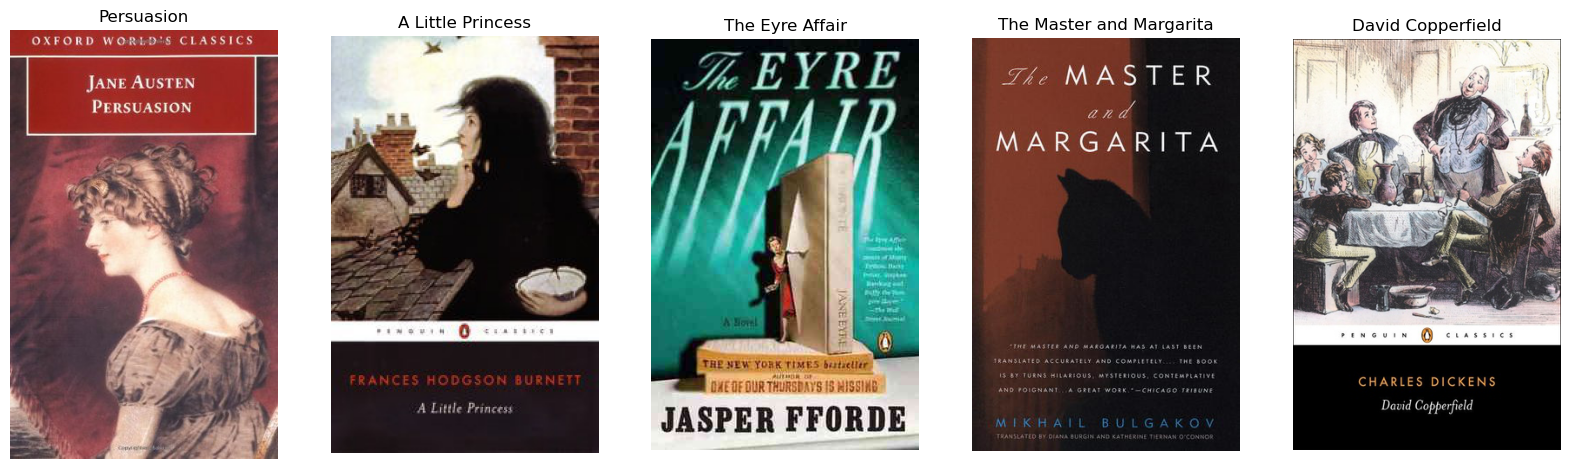

In [63]:
recommendations('Pride and Prejudice')

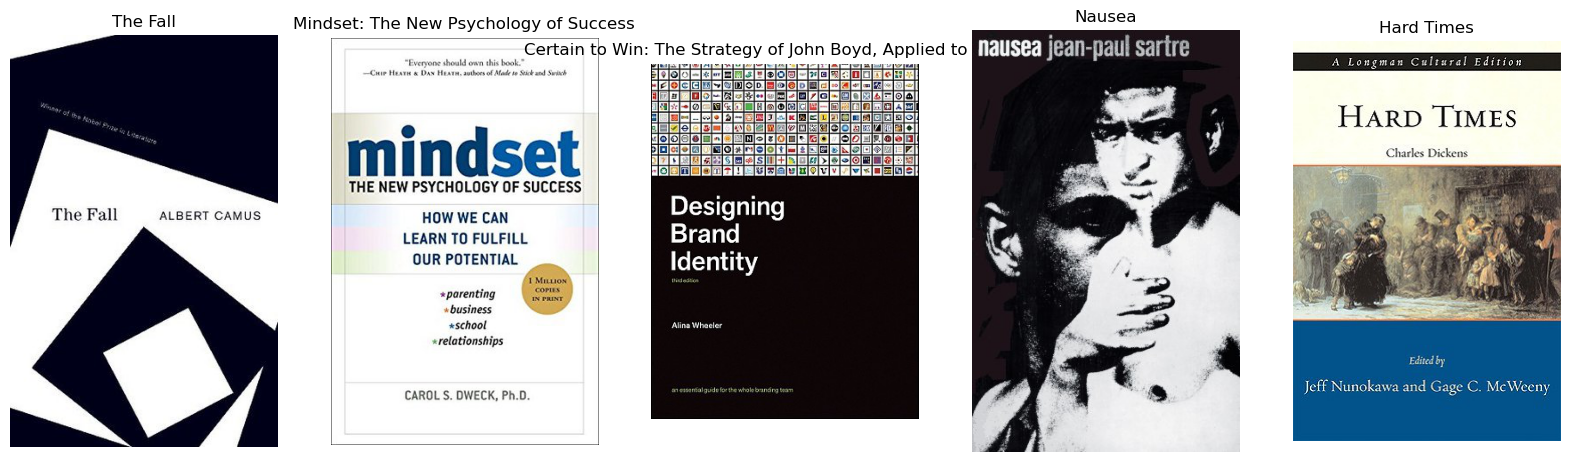

In [64]:
recommendations('The Stranger')

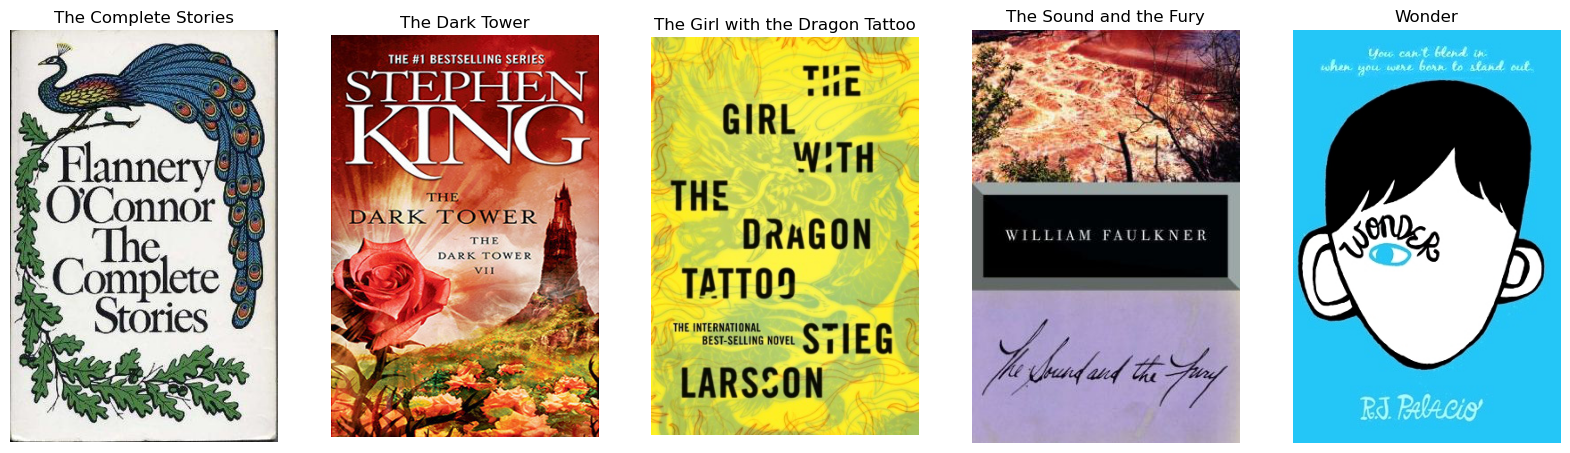

In [65]:
recommendations('The Great Gatsby')